In [5]:
%load_ext autoreload
%autoreload 2
from unityagents import UnityEnvironment
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from collections import deque
from utils.agent import Agent

In [7]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [8]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


Episode 50	Average Scores: 0.00
Episode 100	Average Scores: 0.03
Episode 150	Average Scores: 0.09
Episode 200	Average Scores: 0.21
Episode 250	Average Scores: 0.30
Episode 300	Average Scores: 0.39
Episode 350	Average Scores: 0.43
Episode 400	Average Scores: 0.42
Episode 450	Average Scores: 0.41
Episode 500	Average Scores: 0.53
Episode 550	Average Scores: 0.86

Environment solved (solved > 0.5) after at 394 episodes!	Average Score: 0.87


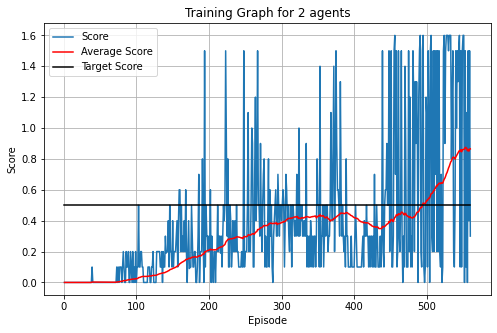

In [11]:
%%time
n_episodes = 1000
max_t = 300
scores_deque = deque(maxlen=100)
scores = []
scores_mean = []

# initiate agent
agent = Agent(num_agents,state_size,action_size)

for i_episode in range(1, n_episodes+1):    
    env_info = env.reset(train_mode=True)[brain_name]
    score = 0
    score_mean = 0
    agent.noise.reset()
    state = env_info.vector_observations
    for i in range(max_t):
        #print(state)
        reward, next_state, done = agent.act(env,brain_name,state)   
        score += max(reward)
        score_mean += np.mean(reward)
        state = next_state
        if np.any(done):    
            break
            
    scores_deque.append(score)    
    scores.append(score)
    scores_mean.append(score_mean)

    
    if i_episode % agent.print_every == 0:
        agent.plotter(scores,scores_mean)
        
    if (np.mean(scores_deque)>=0.5) and (len(scores_deque)==100):
        agent.plotter(scores, solved = True)        
        agent.save_checkpoint()
        break
        
agent.plotter(scores, solved = True, save_plot = True)        

In [ ]:
from utils.actorCritic import ActorPolicy, CriticPolicy
import ujson
import torch
# reset enviroment with train = False
env_info = env.reset(train_mode=False)[brain_name]    
scores = np.zeros(num_agents)    

# initiate trained network
actor_network = ujson.load(open('TrainedModel/MADDPG_Actor_Network.json','r'))
trained_actor = ActorPolicy(state_size, action_size, hidden = actor_network['hidden_layers'],drop_out=0.0)
state_dict_actor = torch.load('TrainedModel/MADDPG_Actor.pth')
trained_actor.load_state_dict(state_dict_actor)

# set to evaluation mode
trained_actor.eval()

for i in range(1,6):
    scores = np.zeros(num_agents)          
    # loop until enviroment is done
    while True:
        # take action
        with torch.no_grad():
            actions = trained_actor(env_info.vector_observations).cpu().data.numpy()
        
        # step
        env_info = env.step(actions)[brain_name]           
        next_states = env_info.vector_observations 

        # add scores
        scores += env_info.rewards  

        # check if complete
        if np.any(env_info.local_done):                                  
            break
    print('Score (max over agents) from episode {}: {:.2f}'.format(i, np.max(scores)))
env.close()

![GIF of Trained Network](Images/Tennis.gif)
